In [1]:
# Run the following lines to reload imported packages automatically
%load_ext autoreload
%autoreload 2

import numpy as np
from icecream import ic

from typing import List, Tuple, Dict

In [2]:
problem = np.load('problem_0.npz')
x = problem['x']
y = problem['y']
x.shape

(2, 1000)

In [3]:
from gxgp import Node

input = x
labels = y

#Single input and output
print(input.shape, labels.shape)
#Print a column of input
print("INPUT")
print(input[:,0])
print("LABEL")
print(labels[0])
#Functional set
from operations.operations_dict import basic_function_set, complex_function_set

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print(terminal_list)

(2, 1000) (1000,)
INPUT
[ 2.37857096 -0.74681473]
LABEL
2.242710018984468
['x0', 'x1']


Tree Generation  

Generation

Drawing the tree...


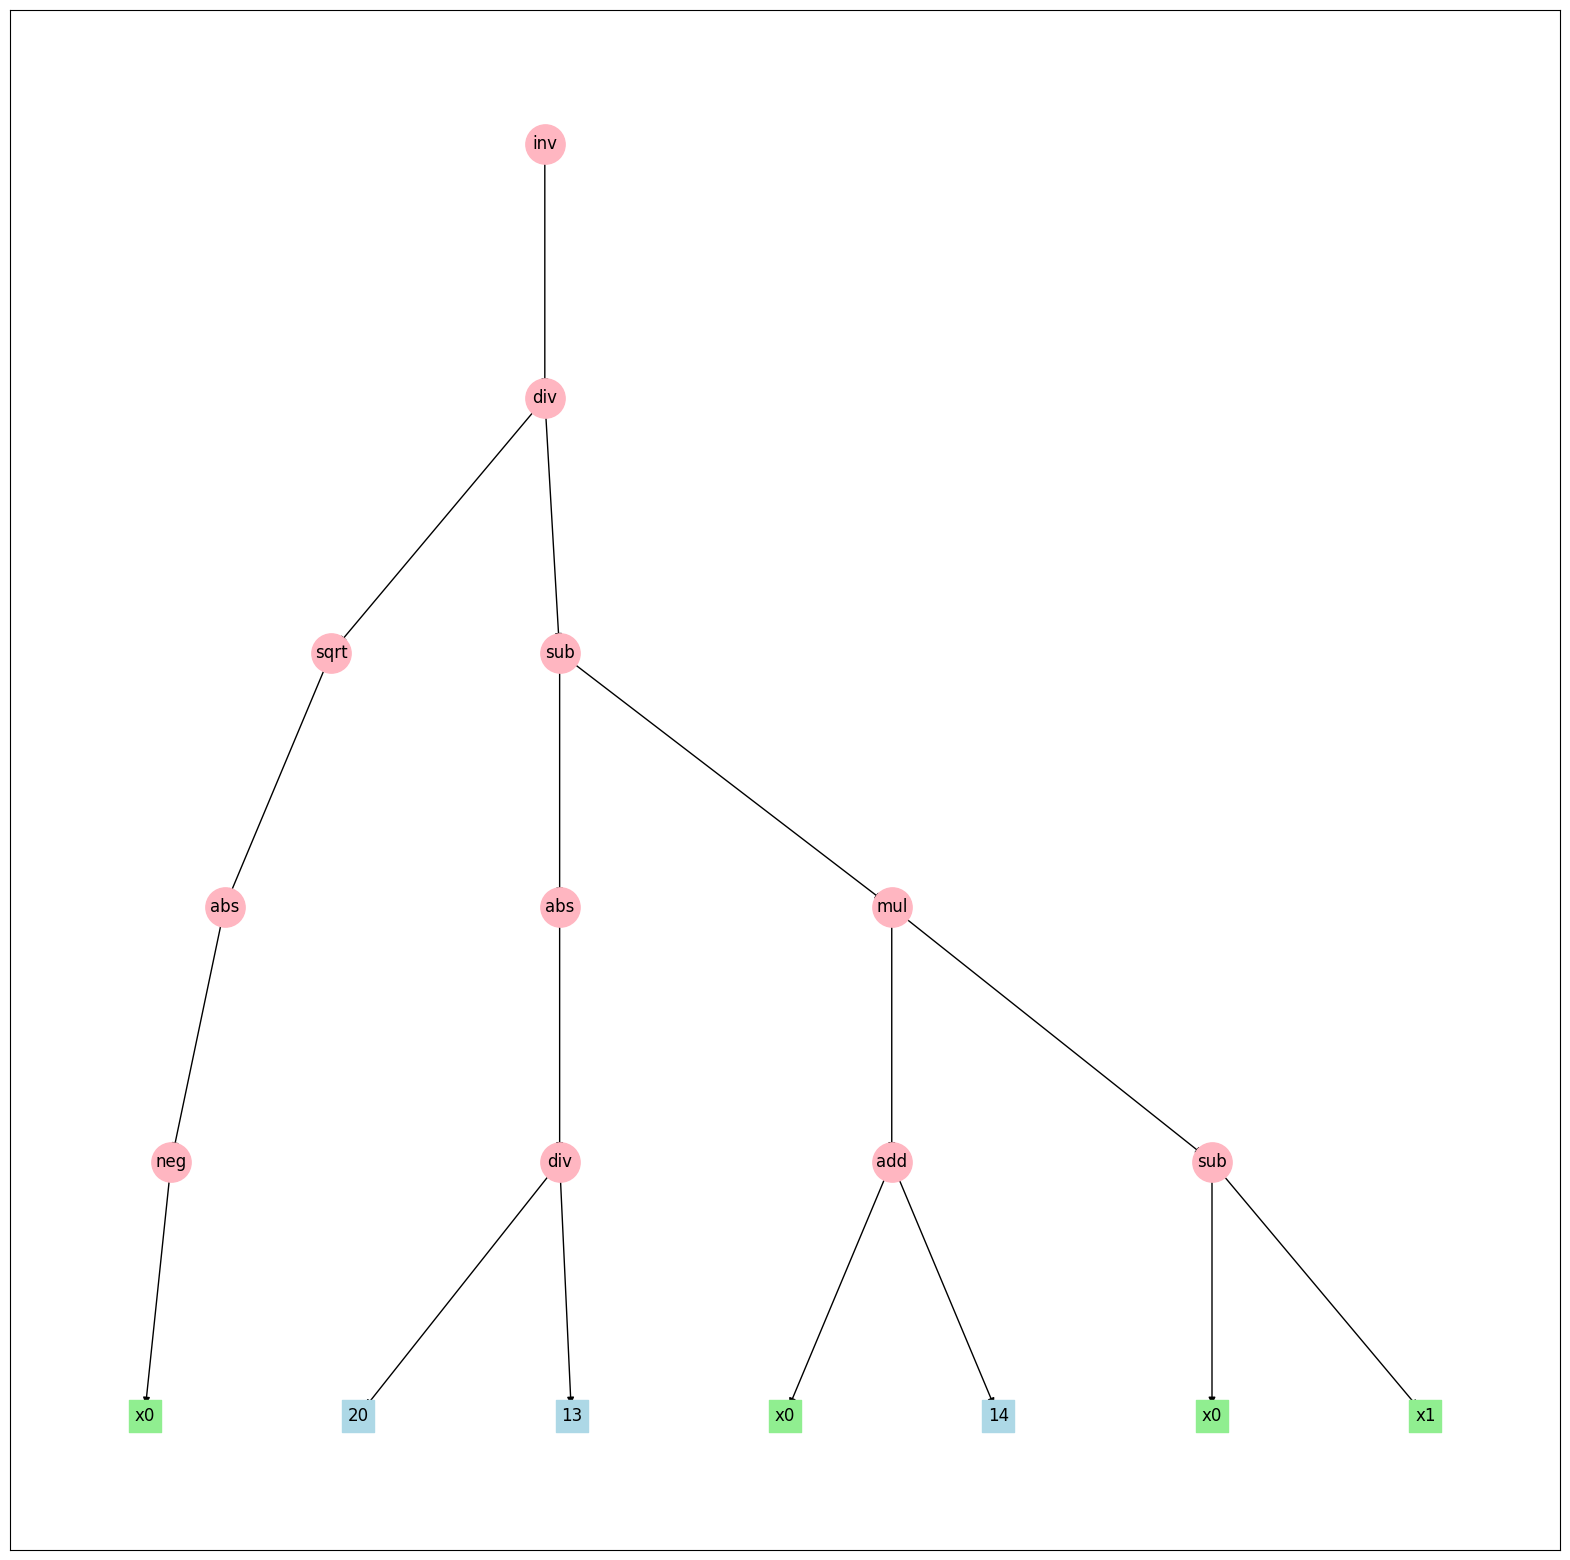

In [8]:
from operations.terminal_constants import crammed_constants
from operations.evolution import generate_random_tree

depth = 5
initialized = generate_random_tree(depth, 0.2, terminal_list, crammed_constants, 0.4, full_tree=True)
initialized.draw(depth)


Create input formatted

In [5]:
vars = {'x'+str(i): input[:,0][i] for i in range(input.shape[0])}
initialized(**vars)

np.float64(-4.986173712839864)

In [6]:
# Fitness
def fitness(mytree, vars, labels):
    return 100*np.square(labels - mytree(**vars)).sum()/len(labels)

In [7]:
from gxgp.gp_common import xover_swap_subtree
# Xover
def xover(tree1, tree2):
    return xover_swap_subtree(tree1, tree2)

initialized.get_random_node().draw()
str(initialized)

TypeError: Node.draw() missing 1 required positional argument: 'depth'

## Training